<a href="https://colab.research.google.com/github/kemaliksn/BrainTumor_Classification/blob/main/TumorOtak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Capstone Model Build**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 15.5 MB/s eta 0:00:00


In [3]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import zipfile
import os

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


• Using TensorFlow Version: 2.15.0
• Using TensorFlow Hub Version:  0.16.1
• GPU Device Found.


In [5]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [6]:
# Dataset Path from Shared GDrive
train_path = "/content/drive/MyDrive/SkripsiKemal/dataset/training.zip"
test_path = "/content/drive/MyDrive/SkripsiKemal/dataset/testing.zip"

In [7]:
# Extract Dataset
with zipfile.ZipFile(train_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [8]:
# Extract Test Set
with zipfile.ZipFile(test_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [9]:
# Create Train, Validation, and Test Path. Also Define The Classes
train_dir = "/content/dataset/Training"
test_dir  = "/content/dataset/Testing"
# test_dir  = "/content/dataset/TEST"

class_names = sorted(os.listdir(train_dir))
label = class_names
print(label)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [17]:
# Resize Image Function using Tensorflow ImageGenerator
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    brightness_range=(0.85, 1.15),
                    fill_mode="nearest")

test_datagen  = ImageDataGenerator(
                    rescale=1./255,
                    validation_split=0.5)

In [18]:
# Resize and Batch Train and Validation Image using ImageGen
train_generator = train_datagen.flow_from_directory(
        train_dir,                # Direktori data latih
        target_size= IMAGE_SIZE,   # Mengubah resolusi seluruh gambar menjadi 224x224 piksel
        batch_size=32,
        classes = label,
        class_mode='categorical',
        subset='training')      # Klasifikasi 2 kelas lebih menggunakan mode = categorical

validation_generator = test_datagen.flow_from_directory(
        test_dir,                  # Direktori data validasi
        target_size= IMAGE_SIZE,   # Mengubah resolusi seluruh gambar menjadi 224x224 piksel
        batch_size=32,
        classes = label,
        class_mode='categorical',
        subset='validation')      # Klasifikasi 2 kelas lebih menggunakan mode = categorical

test_generator = test_datagen.flow_from_directory(
        test_dir,                  # Direktori data test
        target_size= IMAGE_SIZE,   # Mengubah resolusi seluruh gambar menjadi 224x224 piksel
        shuffle = False,
        batch_size=32,
        classes = label,
        class_mode='categorical',
        subset='validation')

Found 5712 images belonging to 4 classes.
Found 655 images belonging to 4 classes.
Found 655 images belonging to 4 classes.


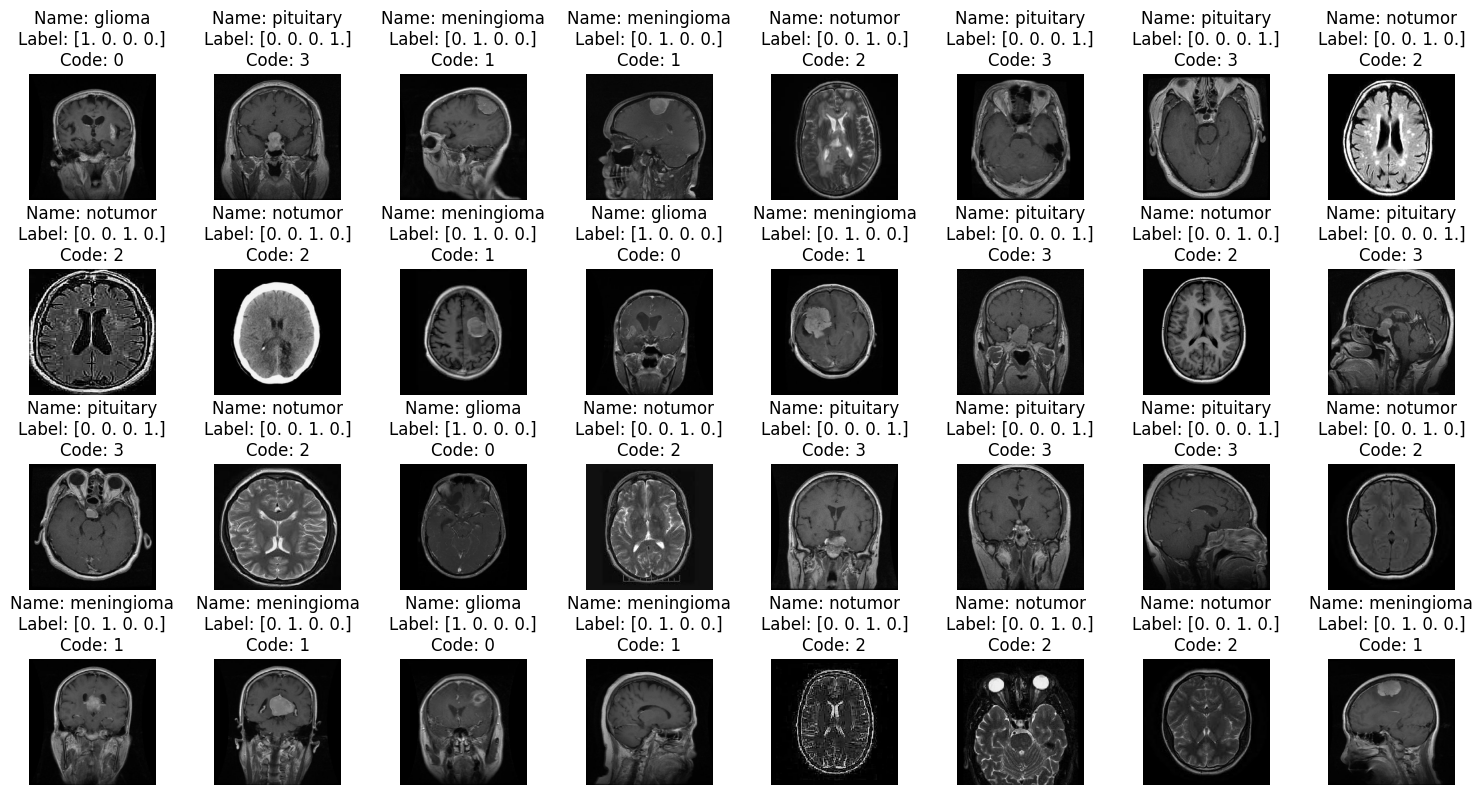

In [19]:
import matplotlib.pyplot as plt

# Memuat satu batch data gambar dari generator
images, labels = next(train_generator)

# Menampilkan gambar dengan visualisasi augmentasi
fig, axes = plt.subplots(4, 8, figsize=(15, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.set_title(f"Name: {label[np.argmax(labels[i])]}\nLabel: {labels[i]}\nCode: {np.argmax(labels[i])}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [20]:
do_fine_tuning = True #@param {type:"boolean"}

In [21]:
# Extract Layer from MobileNet Module
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   output_shape=[FV_SIZE],
                                   trainable= do_fine_tuning)

In [48]:
# Model Build
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_3 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 2228996 (8.50 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


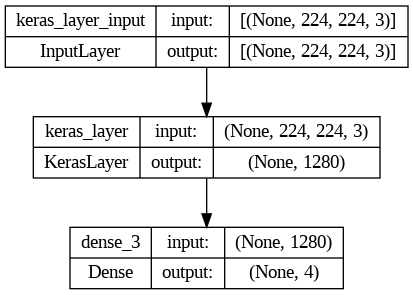

In [49]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [52]:
# Model Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer = optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print(model.optimizer.get_config(),"\n")

{'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False} 



In [58]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97):
            print("\nDesired accuracy and validation_accuracy > 97%")
            self.model.stop_training = True

callbacks = myCallback()

In [62]:
# Training The Model
history = model.fit(
      train_generator,
      steps_per_epoch=20,                          # Berapa batch yang akan dieksekusi pada setiap epoch
      epochs=10,
      validation_data = validation_generator,      # Menampilkan akurasi pengujian data validasi
      validation_steps=20,                         # Berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/10
20/20 - 6s - loss: 0.1255 - accuracy: 0.9859 - val_loss: 0.1926 - val_accuracy: 0.9641 - 6s/epoch - 279ms/step
Epoch 2/10
20/20 - 5s - loss: 0.1513 - accuracy: 0.9797 - val_loss: 0.3661 - val_accuracy: 0.9422 - 5s/epoch - 263ms/step
Epoch 3/10
20/20 - 5s - loss: 0.1659 - accuracy: 0.9781 - val_loss: 0.5493 - val_accuracy: 0.8641 - 5s/epoch - 240ms/step
Epoch 4/10
20/20 - 4s - loss: 0.1110 - accuracy: 0.9937 - val_loss: 0.3837 - val_accuracy: 0.9047 - 4s/epoch - 207ms/step
Epoch 5/10
20/20 - 5s - loss: 0.1219 - accuracy: 0.9875 - val_loss: 0.1672 - val_accuracy: 0.9781 - 5s/epoch - 268ms/step
Epoch 6/10
20/20 - 4s - loss: 0.1611 - accuracy: 0.9812 - val_loss: 0.2320 - val_accuracy: 0.9594 - 4s/epoch - 209ms/step
Epoch 7/10
20/20 - 4s - loss: 0.1881 - accuracy: 0.9766 - val_loss: 0.1996 - val_accuracy: 0.9672 - 4s/epoch - 205ms/step
Epoch 8/10
20/20 - 5s - loss: 0.1320 - accuracy: 0.9875 - val_loss: 0.2222 - val_accuracy: 0.9563 - 5s/epoch - 273ms/step
Epoch 9/10
20/20 - 4s - 

In [63]:
# Evaluating the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

21/21 [==============================] - 2s 89ms/step - loss: 0.1173 - accuracy: 0.9924
Test Accuracy: 0.9923664331436157


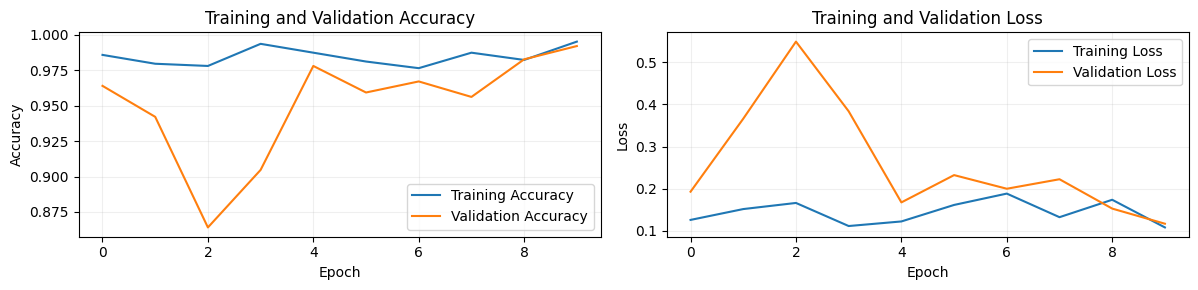

In [64]:
# Mendapatkan data pelatihan
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat plot akurasi dan loss pelatihan bersebelahan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Plot akurasi pelatihan dan validasi
ax1.plot(train_acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(alpha=0.2)

# Plot loss pelatihan dan validasi
ax2.plot(train_loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(alpha=0.2)

plt.tight_layout()
plt.show()

## Predict with Trained Model

Saving gg (491).jpg to gg (491).jpg
Saving gg (492).jpg to gg (492).jpg
Saving gg (493).jpg to gg (493).jpg
Saving gg (494).jpg to gg (494).jpg
Saving gg (495).jpg to gg (495).jpg
Saving gg (496).jpg to gg (496).jpg
Saving gg (497).jpg to gg (497).jpg
Saving gg (498).jpg to gg (498).jpg
Saving gg (499).jpg to gg (499).jpg
Saving gg (500).jpg to gg (500).jpg
1/1 [==============================] - 0s 22ms/step
[[9.9981755e-01 2.1345359e-05 1.5684607e-04 4.3478694e-06]]
gg (491).jpg
Predicted Class: Glioma
1/1 [==============================] - 0s 21ms/step
[[9.9913198e-01 5.0057931e-04 3.4988386e-04 1.7607961e-05]]
gg (492).jpg
Predicted Class: Glioma
1/1 [==============================] - 0s 21ms/step
[[9.9990952e-01 9.8946202e-06 7.8353289e-05 2.2170486e-06]]
gg (493).jpg
Predicted Class: Glioma
1/1 [==============================] - 0s 24ms/step
[[9.9995863e-01 3.1804325e-06 3.7195987e-05 9.6211761e-07]]
gg (494).jpg
Predicted Class: Glioma
1/1 [==============================] - 0s 23

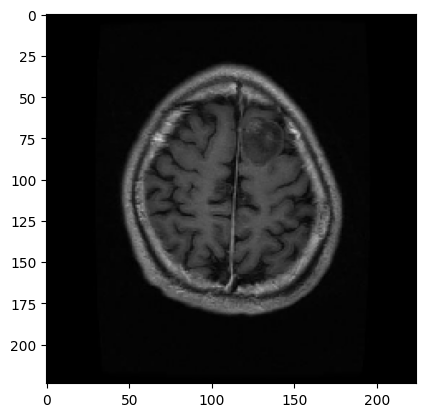

In [87]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size= IMAGE_SIZE)

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)
  print(classes)
  print(fn)
  # Define class labels
  class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

  # Use argmax to find the index of the class with the highest probability
  predicted_class_index = np.argmax(classes)

  # Get the corresponding class label
  predicted_class = class_labels[predicted_class_index]

  print("Predicted Class:", predicted_class)

  # if classes[0,0]>0.5:
  #   print("Glioma")
  # elif classes[0,1]>0.5:
  #   print('Meningioma')
  # elif classes[0,2]>0.5:
  #   print('No Tumor')
  # else:
  #   print("Pituitary")

## Convert to Model to TFLite

In [ ]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = "/content/dataset/BN_Material/model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {tflite_model_path}")

TFLite model saved to: /content/dataset/BN_Material/model.tflite


## Predict with Converted TFLite Model

Saving download (1).jpg to download (1).jpg
Saving Limbah-Baterai-1.jpg to Limbah-Baterai-1.jpg
Saving Screen-Shot-2021-09-08-at-16.46.19.jpg to Screen-Shot-2021-09-08-at-16.46.19.jpg
Saving bootle.webp to bootle.webp
Saving bootlee.webp to bootlee.webp
Saving bootllee.jpg to bootllee.jpg
Saving plastcic.png to plastcic.png
Saving placstic.jpg to placstic.jpg
Saving sampah-organik-64d6d7e74addee208827ff52.jpg to sampah-organik-64d6d7e74addee208827ff52.jpg
Saving makanan-sisa-kondangan-3_169.jpeg to makanan-sisa-kondangan-3_169.jpeg
download (1).jpg
Sampah Anorganik
Limbah-Baterai-1.jpg
Sampah Anorganik
Screen-Shot-2021-09-08-at-16.46.19.jpg
Sampah Anorganik
bootle.webp
Sampah Anorganik
bootlee.webp
Sampah Anorganik
bootllee.jpg
Sampah Anorganik
plastcic.png
Sampah Anorganik
placstic.jpg
Sampah Anorganik
sampah-organik-64d6d7e74addee208827ff52.jpg
Sampah Anorganik
makanan-sisa-kondangan-3_169.jpeg
Sampah Anorganik


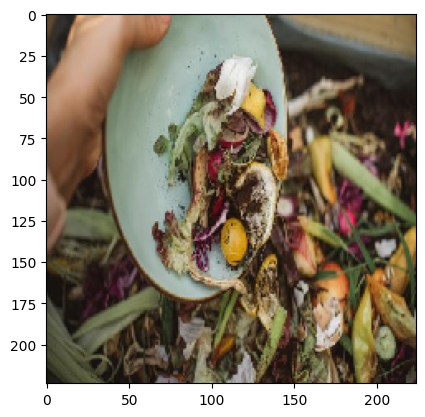

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = fn
    img = image.load_img(path, target_size=IMAGE_SIZE)

    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], x)

    # Run inference
    interpreter.invoke()

    # Get the output
    output = interpreter.get_tensor(output_details[0]['index'])

    print(fn)
    if output[0] > 0.5:
        print("Sampah Anorganik")
    else:
        print("Sampah Organik")

## Coba-Coba Convert Model to .h5

In [ ]:
# Save the model as an HDF5 file
model.save('/content/drive/Shareddrives/Dataset/model.h5')

# Alternatively, you can save the model to the current working directory
# model.save('your_model_name.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saving download (1).jpg to download (1) (1).jpg
Saving Limbah-Baterai-1.jpg to Limbah-Baterai-1 (1).jpg
Saving Screen-Shot-2021-09-08-at-16.46.19.jpg to Screen-Shot-2021-09-08-at-16.46.19 (1).jpg
Saving bootle.webp to bootle (1).webp
Saving bootlee.webp to bootlee (1).webp
Saving bootllee.jpg to bootllee (1).jpg
Saving plastcic.png to plastcic (1).png
Saving placstic.jpg to placstic (1).jpg
Saving sampah-organik-64d6d7e74addee208827ff52.jpg to sampah-organik-64d6d7e74addee208827ff52 (1).jpg
Saving makanan-sisa-kondangan-3_169.jpeg to makanan-sisa-kondangan-3_169 (1).jpeg
1/1 [==============================] - 1s 993ms/step
download (1) (1).jpg
Sampah Anorganik)
1/1 [==============================] - 0s 88ms/step
Limbah-Baterai-1 (1).jpg
Sampah Anorganik)
1/1 [==============================] - 0s 75ms/step
Screen-Shot-2021-09-08-at-16.46.19 (1).jpg
Sampah Anorganik)
1/1 [==============================] - 0s 83ms/step
bootle (1).webp
Sampah Anorganik)
1/1 [==============================]

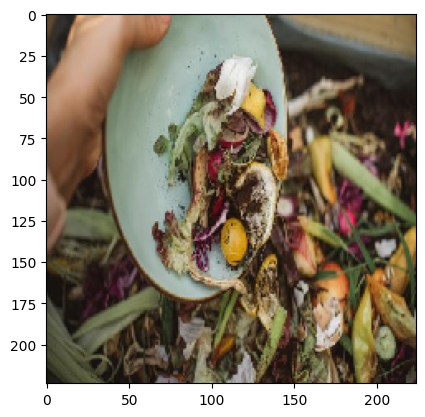

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline

# Define the custom object for TensorFlow Hub KerasLayer
class HubKerasLayer(hub.KerasLayer):
    pass

# Load the saved model with custom objects
model_path = "/content/drive/Shareddrives/Dataset/model.h5"
custom_objects = {'KerasLayer': HubKerasLayer}
model = load_model(model_path, custom_objects=custom_objects)

uploaded = files.upload()

for fn in uploaded.keys():
    # Predicting images
    path = fn
    img = image.load_img(path, target_size=(224, 224))

    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    # Make predictions
    predictions = model.predict(x)

    print(fn)
    if predictions[0] > 0.5:
        print("Sampah Anorganik)")
    else:
        print("Sampah Organik)")

## Coba-Coba Convert Model to .h5 (Coursera)

In [ ]:
!pip install tensorflowjs

In [ ]:
import time
saved_model_path = "/tmp/saved_model/{}".format(int(time.time()))

tf.keras.experimental.export_saved_model(model, saved_model_path)

In [ ]:
!tensorflowjs_converter \
    --input_format=keras_saved_model \
    /tmp/saved_models/  \
    /tmp/classification

In [ ]:
model.save("/tmp/model.h5");
!tensorflowjs_converter \
    --input_format=keras \
    /tmp/model.h5 \
     /tmp/model.h5

## Coba-Coba Model Export

In [ ]:
B_N_SAVED_MODEL = "exp_saved_model"

In [ ]:
tf.saved_model.save(model, B_N_SAVED_MODEL)

In [ ]:
%%bash -s $B_N_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

In [ ]:
loaded = tf.saved_model.load(B_N_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(B_N_SAVED_MODEL)

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:
def representative_data_gen():
    # You can adjust the number of batches according to your needs
    for _ in range(100):
        input_value, _ = next(test_generator)
        yield [input_value]

In [ ]:
converter.representative_dataset = representative_data_gen

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
except:
    pass